# Deduce internal wave direction from ADCP and mooring data

Refs: 
    - Mirshak and Kelley, 2008, JAOTEC
    - Chang et al, 2011, JAOTEC
      
$$
\theta_P = \arctan \left( \frac{v}{u}\right)
$$


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mycurrents import oceanmooring as om
import soda.dataio as io
from soda.utils.otherplot import polar_pdf, axcolorbar
from soda.utils.myairsea import pol2compass

from netCDF4 import Dataset
from datetime import datetime

from matplotlib import rcParams


%matplotlib inline

# Set font sizes
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'


/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/suntans/.config/matplotlib/matplotlibrc", line #35
  (fname, cnt))


In [2]:
####
adcpfile = '../Data/NetCDF/KISSME2017_RDI_QAQC.nc'

Tfile = '../Data/NetCDF/KISSME_Gridded_Mooring_TP_60sec.nc'

dbfile = '../KISSME2017_Obs.db'


site = 'SP'

if site=='WP':
    group1 = 'WP250_RDI_150_kHz_Quartermaster_11795'
    group2 = 'WP250_RDI_300_kHz_Sentinel_20092'
    Tgroup = 'WP250'
elif site=='SP':
    group1 = 'SP250_RDI75_kHz_Longranger_24613'
    group2 = None
    Tgroup = 'SP250'
elif site=='NP':
    group1 = 'NP250_RDI_150_kHz_Quartermaster_16856'
    group2 = 'NP250_RDI_300_kHz_Monitor_20089'
    Tgroup = 'NP250'
    


In [3]:
#####
# List the groups in the file
#nc = Dataset(adcpfile)
#for gg in nc.groups.keys():
#    print gg
#nc.close()

# Load the moorings
u = om.from_netcdf(adcpfile, 'u', group=group1)
v = om.from_netcdf(adcpfile, 'v', group=group1)
w = om.from_netcdf(adcpfile, 'w', group=group1)
if group2 is not None:
    u2 = om.from_netcdf(adcpfile, uvar, group=group2)
T = om.from_netcdf(Tfile, 'temperature', group=Tgroup)

In [121]:
# Whole data set
t1 = datetime(2017,4,2,12,0,0,0)
t2 = datetime(2017,4,13,0,0,0,0)

# Big waves!!
#t1 = datetime(2017,4,2,16,0,0,0)
#t2 = datetime(2017,4,6,22,0,0,0)

# Big mode-2 event
t1 = datetime(2017,5,6,7,20,0,0)
t2 = datetime(2017,5,6,8,20,0,0)

# A soliton example
#t1 = datetime(2017,4,3,8,10,0,0)
#t2 = datetime(2017,4,3,8,40,0,0)

# CTD day 1
#t1 = datetime(2017,4,2,22,0,0,0)
#t2 = datetime(2017,4,3,12,0,0,0)

# First few days
#t1 = datetime(2017,4,2,1,0,0,0)
#t2 = datetime(2017,4,7,1,0,0,0)


# Clip the time series
uc = u.clip(t1,t2)
vc = v.clip(t1,t2)
wc = w.clip(t1,t2)
Tc = T.clip(t1,t2)


(<matplotlib.contour.QuadContourSet at 0x7f794c3e1210>,
 <matplotlib.colorbar.Colorbar at 0x7f794c1aa750>)

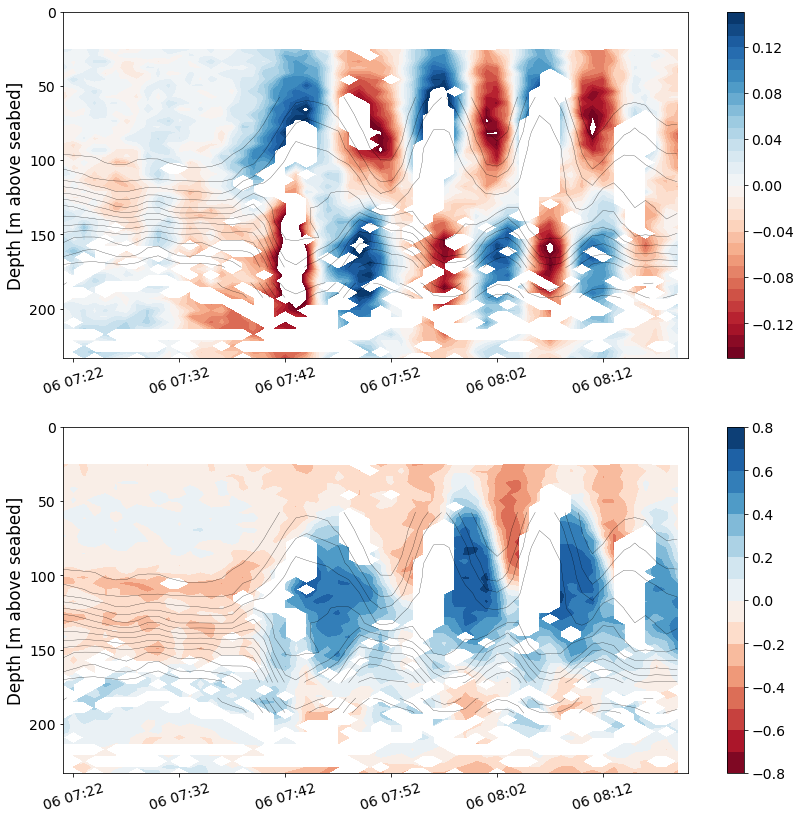

In [123]:
# Contour plot w and T
plt.figure(figsize=(14,14))

ax=plt.subplot(211)
Tc.contourf(np.arange(12,31,1), cbar=False, filled=False)

wc.contourf(np.arange(-0.15,0.16,0.01), cbar=True, filled=True, cmap='RdBu')

ax = plt.subplot(212)
Tc.contourf(np.arange(12,31,1), cbar=False, filled=False)

uc.contourf(np.arange(-0.8,0.9,0.1), cbar=True, filled=True, cmap='RdBu')

In [124]:
# Calculate the barotropic, surface and seabed velocities
ubar = uc.depthavg()
vbar = vc.depthavg()

us = uc.interp_z(50.)
vs = vc.interp_z(50.)

ub = uc.interp_z(210.)
vb = vc.interp_z(210.)

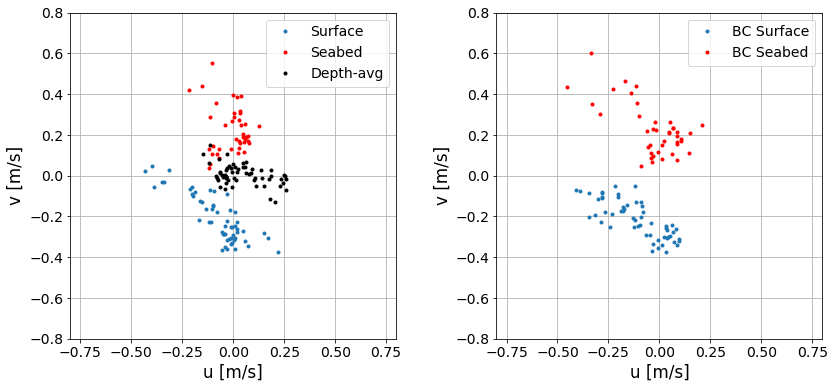

In [125]:
# Scatter plot of surface and seabed velocity
plt.figure(figsize=(14,6))
ax = plt.subplot(121)
plt.plot(us,vs,'.')
plt.plot(ub,vb,'r.')
plt.plot(ubar,vbar,'k.')
plt.axis([-0.8,0.8,-0.8,0.8])
ax.set_aspect('equal')
plt.legend(('Surface', 'Seabed','Depth-avg'))
plt.grid(b=True)
plt.xlabel('u [m/s]')
plt.ylabel('v [m/s]')


ax = plt.subplot(122)
plt.plot(us-ubar,vs-vbar,'.')
plt.plot(ub-ubar,vb-vbar,'r.')

plt.axis([-0.8,0.8,-0.8,0.8])
ax.set_aspect('equal')
plt.legend(('BC Surface', 'BC Seabed'))

plt.grid(b=True)
plt.xlabel('u [m/s]')
plt.ylabel('v [m/s]')

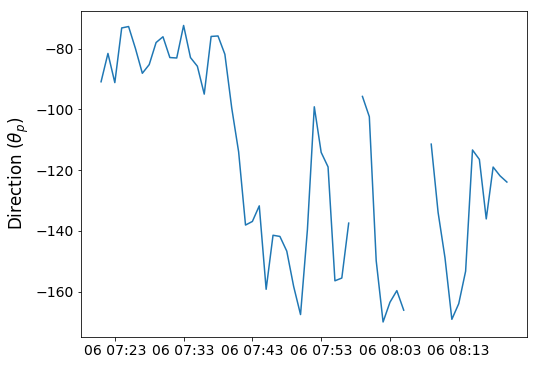

In [126]:
# Calculate the direction
rad2deg = 180./np.pi
thetap = np.arctan2(vs-vbar, us-ubar) * rad2deg
#thetap = np.arctan2(vs, us) * rad2deg

plt.figure(figsize=(8,6))
plt.plot(uc.t, thetap)
plt.ylabel(r'Direction ($\theta_p$)')

# Look at the differences in isopycnal displacement

In [127]:
T_NP = om.from_netcdf(Tfile, 'temperature', group='NP250').clip(t1,t2)
T_SP = om.from_netcdf(Tfile, 'temperature', group='SP250').clip(t1,t2)
T_WP = om.from_netcdf(Tfile, 'temperature', group='WP250').clip(t1,t2)

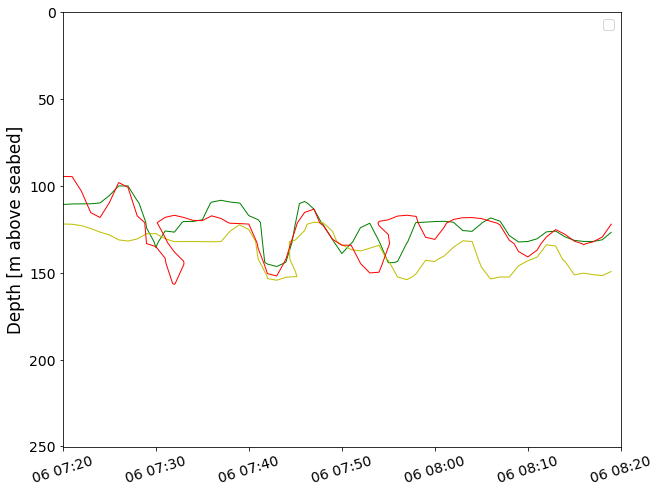

In [128]:
#plt.figure(figsize=(14,14))
plt.figure(figsize=(10,8))

#Tlevs = [24,25,26]
Tlevs = [24]
ax=plt.subplot(111)
T_NP.contourf(Tlevs, cbar=False, filled=False,linewidths=1, colors='g')
T_SP.contourf(Tlevs, cbar=False, filled=False, colors='y',linewidths=1)
T_WP.contourf(Tlevs, cbar=False, filled=False, colors='r',linewidths=1)

plt.legend(('NP','SP','WP'))

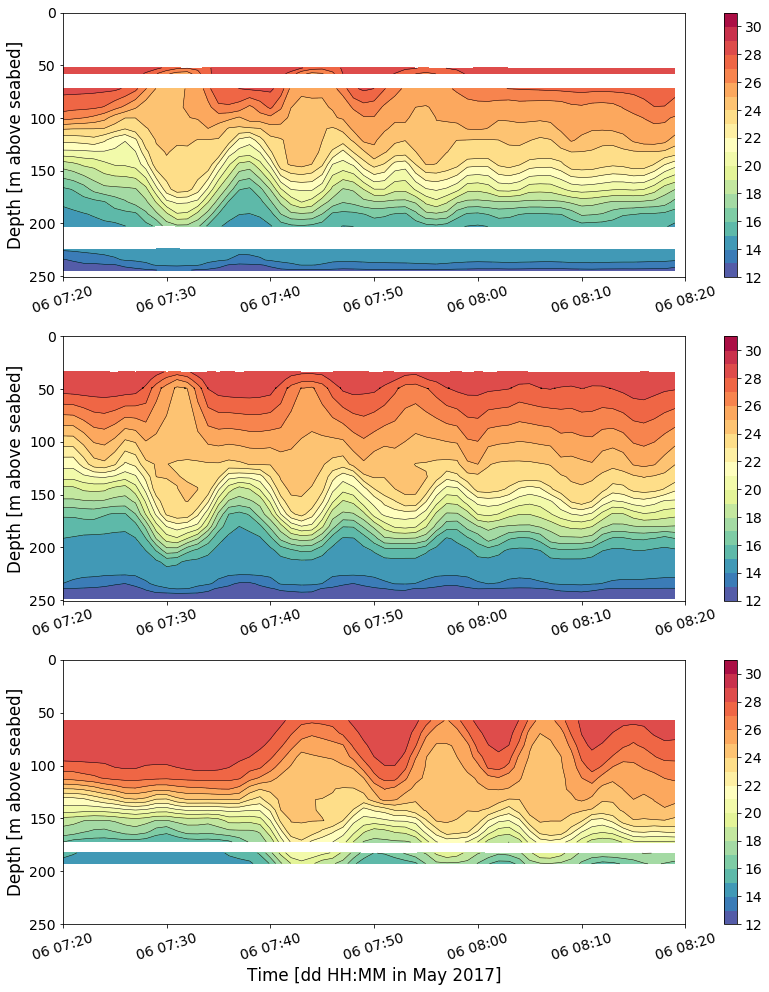

In [142]:
plt.figure(figsize=(12,14))
plt.subplot(311)
T_NP.contourf(np.arange(12,32), cbar=True, filled=True, colors='k',linewidths=1)
T_NP.contourf(np.arange(12,32), cbar=False, filled=False, colors='k',linewidths=0.5)

plt.subplot(312)
T_WP.contourf(np.arange(12,32), cbar=True, filled=True, colors='k',linewidths=1)
T_WP.contourf(np.arange(12,32), cbar=False, filled=False, colors='k',linewidths=0.5)

plt.subplot(313)
T_SP.contourf(np.arange(12,32), cbar=True, filled=True, colors='k',linewidths=1)
T_SP.contourf(np.arange(12,32), cbar=False, filled=False, colors='k',linewidths=0.5)

plt.xlabel('Time [dd HH:MM in May 2017]')
plt.tight_layout()
plt.savefig('../FIGURES/Gnarly_Mode2_Soliton.png')

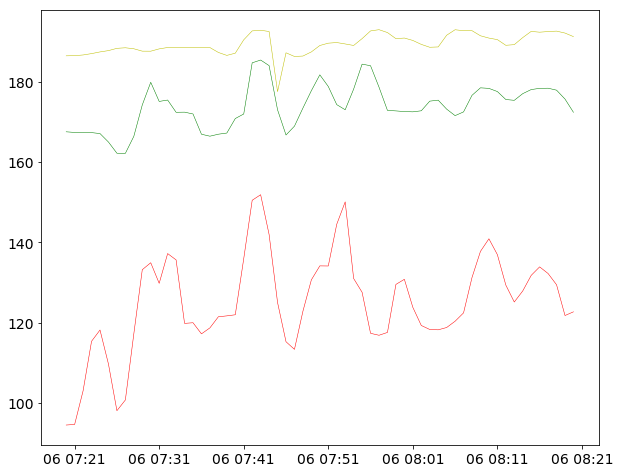

In [130]:
# Extract the isotherm displacement 

T_NP_25 = T_NP.isoslice(24)
T_SP_25 = T_SP.isoslice(24)
T_WP_25 = T_WP.isoslice(24)

plt.figure(figsize=(10,8))
plt.plot(T_NP.t, T_NP_25,'g', lw=0.5)
plt.plot(T_NP.t, T_SP_25,'y', lw=0.5)
plt.plot(T_NP.t, T_WP_25,'r', lw=0.5)

# Use gradient in a plane to deduce direction

$$
\frac{\eta_y}{\eta_x} = \tan \theta
$$

In [131]:
def gradplane(xA, xB, xC, yA, yB, yC, zA, zB, zC):

    ABx = xB - xA
    ABy = yB - yA
    ABz = zB - zA
    
    ACx = xC - xA
    ACy = yC - yA
    ACz = zC - zA
    
    mx = ABy*ACz - ABz*ACy
    my = ABz*ACx - ABx*ACz
    mz = ABx*ACy - ACx*ABy
    
    return -mx/mz, -my/mz


In [132]:
# Need to convert lat/lon into Easting/Northing
from soda.utils.myproj import MyProj

P = MyProj(None, utmzone=51, isnorth=False)

x_NP, y_NP = P.to_xy(T_NP.X, T_NP.Y)
x_SP, y_SP = P.to_xy(T_SP.X, T_SP.Y)
x_WP, y_WP = P.to_xy(T_WP.X, T_WP.Y)

print x_NP, x_SP, x_WP
print y_NP, y_SP, y_WP

ones = np.ones_like(T_NP_25)

eta_x, eta_y = gradplane(x_SP*ones, x_NP*ones, x_WP*ones,\
                        y_SP*ones, y_NP*ones, y_WP*ones,\
                        T_SP_25, T_NP_25, T_WP_25)
eta_mag = np.abs(eta_x+1j*eta_y)
# Calculate the dirction
theta_p2 = np.arctan2(eta_y, eta_x) 
theta_deg = pol2compass(theta_p2)
#theta_p2 = np.angle(eta_x + 1j*eta_y) *rad2deg

538213.900111 538288.791224 537726.828638
8478555.95204 8478024.98585 8478136.4015


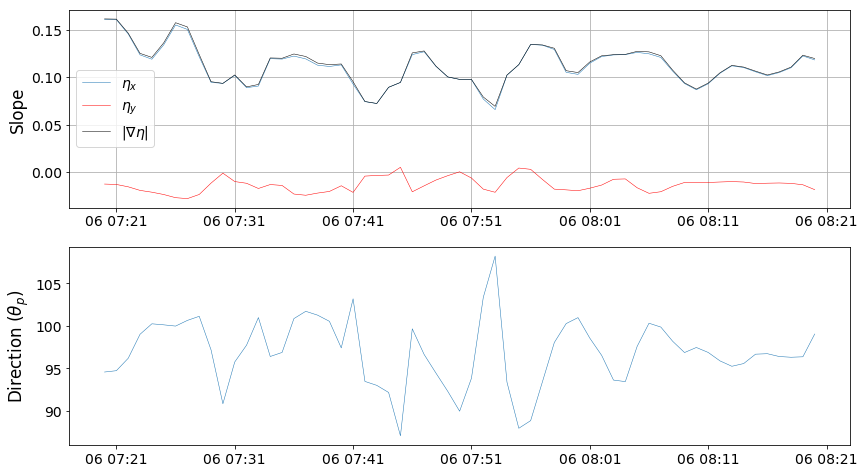

In [133]:
plt.figure(figsize=(14,8))
ax = plt.subplot(211)
plt.plot(T_NP.t, eta_x, lw=0.5)
plt.plot(T_NP.t, eta_y,'r', lw=0.5)
plt.plot(T_NP.t, eta_mag,'k', lw=0.5)
plt.legend(('$\eta_x$','$\eta_y$',r'$|\nabla \eta|$'))
plt.grid(b=True)
plt.ylabel('Slope')

ax = plt.subplot(212)
plt.plot(T_NP.t, theta_deg, lw=0.5)
plt.ylabel(r'Direction ($\theta_p$)')

(360, 0)

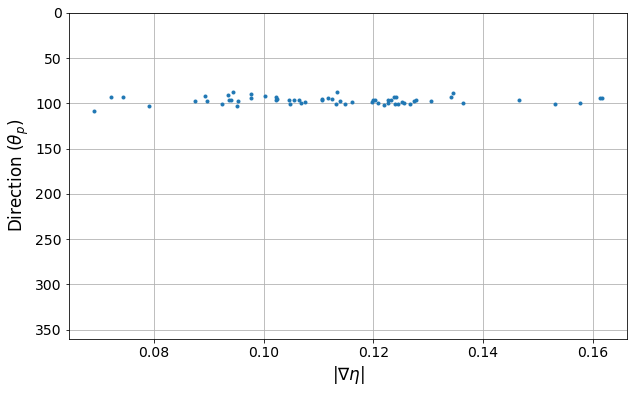

In [134]:
plt.figure(figsize=(10,6))
plt.plot(eta_mag, theta_deg, '.')
plt.xlabel(r'$| \nabla \eta|$')
plt.ylabel(r'Direction ($ \theta_p$)')
plt.grid(b=True)
plt.ylim(360,0)

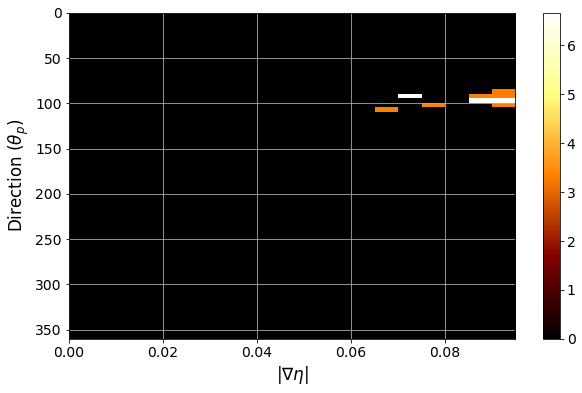

In [135]:
# Histogram of the above
magbins = np.arange(0.0,0.1, 0.005)
dirbins = np.arange(0,365,5)

plt.figure(figsize=(10,6))
H, yedges, xedges = np.histogram2d(theta_deg, eta_mag,   bins=(dirbins, magbins), normed=True)
magbins.shape, dirbins.shape, H.shape
im = plt.imshow(H, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            aspect='auto',
              cmap='afmhot')

plt.xlabel(r'$| \nabla \eta|$')
plt.ylabel(r'Direction ($ \theta_p$)')

plt.colorbar()
plt.ylim(360,0)
plt.grid(b=True)

In [136]:
magbins

array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ,  0.035,
        0.04 ,  0.045,  0.05 ,  0.055,  0.06 ,  0.065,  0.07 ,  0.075,
        0.08 ,  0.085,  0.09 ,  0.095])